In [1]:
import sys
sys.path.append('../')
from SynRBL.rsmi_utils import *
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
from SynRBL.rsmi_utils import load_database, filter_data
reactions_clean = load_database('../Data/reaction_clean.json.gz')
filtered_data_1 = filter_data(reactions_clean, unbalance_values=['Reactants', 'Products'], formula_key='Diff_formula', element_key='C', min_count=1, max_count=10000)
len(filtered_data_1)

13752

In [2]:
filtered_data_2 = filter_data(reactions_clean, unbalance_values=['Both'], formula_key='Diff_formula', element_key='C', min_count=0, max_count=10000)
len(filtered_data_2)

3088

In [3]:
filtered_data = filtered_data_1 + filtered_data_2
len(filtered_data)

16840

In [120]:
from rdkit import Chem
from rdkit.Chem import rdmolops
from rdkit.Chem import rdFMCS

class MCSMissingGraphAnalyzer:
    """A class for detecting missing graph in reactants and products using MCS and RDKit."""

    def __init__(self):
        """Initialize the MolecularOperations class."""
        pass
    
    @staticmethod
    def get_smiles(reaction_dict):
        """
        Extract reactant and product SMILES strings from a reaction dictionary.

        Parameters:
        - reaction_dict: dict
            A dictionary containing 'reactants' and 'products' as keys.

        Returns:
        - tuple
            A tuple containing reactant SMILES and product SMILES strings.
        """
        return reaction_dict['reactants'], reaction_dict['products']

    @staticmethod
    def convert_smiles_to_molecule(smiles):
        """
        Convert a SMILES string to an RDKit molecule object.

        Parameters:
        - smiles: str
            The SMILES string representing a molecule.

        Returns:
        - rdkit.Chem.Mol
            The RDKit molecule object.
        """
        return Chem.MolFromSmiles(smiles)

    @staticmethod
    def mol_to_smiles(mol):
        """
        Convert an RDKit molecule object to a SMILES string.

        Parameters:
        - mol: rdkit.Chem.Mol
            The RDKit molecule object.

        Returns:
        - str or None
            The SMILES string representation of the molecule, or None if the molecule is None.
        """
        return Chem.MolToSmiles(mol) if mol else None

    @staticmethod
    def mol_to_smarts(mol):
        """
        Convert an RDKit molecule object to a SMARTS string.

        Parameters:
        - mol: rdkit.Chem.Mol
            The RDKit molecule object.

        Returns:
        - str or None
            The SMARTS string representation of the molecule, or None if the molecule is None.
        """
        return Chem.MolToSmarts(mol) if mol else None

    @staticmethod
    def find_maximum_common_substructure(mol1, mol2, ringMatchesRingOnly=True):
        """
        Find the maximum common substructure (MCS) between two molecules.

        Parameters:
        - mol1, mol2: rdkit.Chem.Mol
            The RDKit molecule objects to compare.

        Returns:
        - rdkit.Chem.Mol or None
            The RDKit molecule object representing the MCS, or None if MCS search was canceled.
        """
        mcs_result = rdFMCS.FindMCS([mol1, mol2], ringMatchesRingOnly=ringMatchesRingOnly)
        if mcs_result.canceled:
            return None
        mcs_mol = Chem.MolFromSmarts(mcs_result.smartsString)
        return mcs_mol

    def IterativeMCSReactionPairs(reactant_mol_list, product_mol, params=None):
        """
        Find the MCS for each reactant fragment with the product, updating the product after each step.
        Sorts the reactants based on the size of their MCS with the product.

        Parameters:
        - reactant_mol_list: list of rdkit.Chem.Mol
            List of RDKit molecule objects for reactants.
        - product_mol: rdkit.Chem.Mol
            RDKit molecule object for the product.

        Returns:
        - list of rdkit.Chem.Mol
            List of RDKit molecule objects representing the MCS for each reactant-product pair.
        - list of rdkit.Chem.Mol
            Sorted list of reactant molecule objects.
        """
        # Calculate the MCS for each reactant with the product
        mcs_results = [(reactant, rdFMCS.FindMCS([reactant, product_mol], params)) for reactant in reactant_mol_list]

        # Filter out any canceled MCS results and sort by size of MCS
        mcs_results = [(reactant, mcs_result) for reactant, mcs_result in mcs_results if not mcs_result.canceled]
        sorted_reactants = sorted(mcs_results, key=lambda x: x[1].numAtoms, reverse=True)

        mcs_list = []
        current_product = product_mol

        # Process the sorted reactants
        for reactant, mcs_result in sorted_reactants:
            mcs_mol = Chem.MolFromSmarts(mcs_result.smartsString)
            mcs_list.append(mcs_mol)

            # Update the product by removing the MCS substructure
            current_product = Chem.DeleteSubstructs(Chem.RWMol(current_product), mcs_mol)
            try:
                Chem.SanitizeMol(current_product)
            except:
                pass
        
        # raise error if the number of atoms in the current MCS is equal or less than the number of atoms in the current products
        # which means can not identify the missing parts correctly, so just remove this data
        if int(mcs_mol.GetNumAtoms()) <= int(current_product.GetNumAtoms()):
            mcs_list = []

        # Extract only the reactant molecules from sorted_reactants for return
        sorted_reactant_mols = [reactant for reactant, _ in sorted_reactants]

        return mcs_list, sorted_reactant_mols

    
    @staticmethod
    def add_hydrogens_to_radicals(mol):
        """
        Add hydrogen atoms to radical sites in a molecule.

        Parameters:
        - mol: rdkit.Chem.Mol
            RDKit molecule object.

        Returns:
        - rdkit.Chem.Mol
            The modified molecule with added hydrogens.
        """
        if mol:
            # Create a copy of the molecule
            mol_with_h = Chem.RWMol(mol)

            # Add explicit hydrogens (not necessary if they are already present in the input molecule)
            mol_with_h = rdmolops.AddHs(mol_with_h)

            # Find and process radical atoms
            for atom in mol_with_h.GetAtoms():
                num_radical_electrons = atom.GetNumRadicalElectrons()
                if num_radical_electrons > 0:
                    atom.SetNumExplicitHs(atom.GetNumExplicitHs() + num_radical_electrons)
                    atom.SetNumRadicalElectrons(0)
            curate_mol = Chem.RemoveHs(mol_with_h)
            # Return the molecule with added hydrogens
            return curate_mol

    @staticmethod
    def fit(reaction_dict, params=None):
        """
        Process a reaction dictionary to find MCS, missing parts in reactants and products.

        Parameters:
        - reaction_dict: dict
            A dictionary containing 'reactants' and 'products' as keys.

        Returns:
        - tuple
            A tuple containing lists of MCS, missing parts in reactants, missing parts in products,
            reactant molecules, and product molecules.
        """
        reactant_smiles, product_smiles = MCSMissingGraphAnalyzer.get_smiles(reaction_dict)
        reactant_mol_list = [MCSMissingGraphAnalyzer.convert_smiles_to_molecule(smiles) for smiles in reactant_smiles.split('.')]
        product_mol = MCSMissingGraphAnalyzer.convert_smiles_to_molecule(product_smiles)

        mcs_list, sorted_reactants = MCSMissingGraphAnalyzer.IterativeMCSReactionPairs(reactant_mol_list, product_mol,  params)

        return mcs_list , sorted_reactants, product_mol

In [121]:
def get_params(RingMatchesRingOnly = False, CompleteRingsOnly=False):
    params = rdFMCS.MCSParameters()
    params.AtomTyper = rdFMCS.AtomCompare.CompareElements
    #params.BondTyper = rdFMCS.BondCompare.CompareOrder
    params.BondCompareParameters.RingMatchesRingOnly = RingMatchesRingOnly
    params.BondCompareParameters.CompleteRingsOnly = CompleteRingsOnly
    #params.threshold = 50 / 100.0


In [122]:
params = get_params(RingMatchesRingOnly=True, CompleteRingsOnly=True)
params

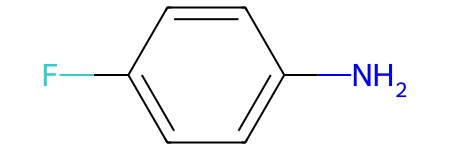

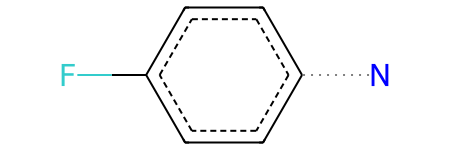

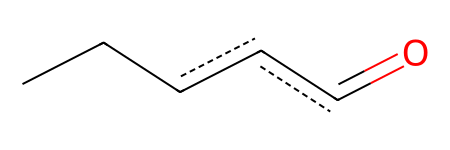

[16:08:06] non-ring atom 2 marked aromatic


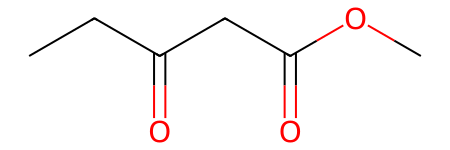

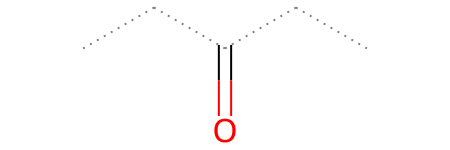

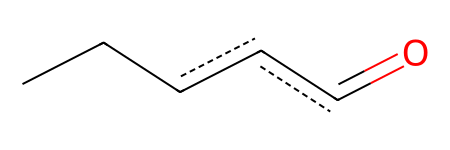

6 6


[16:08:06] non-ring atom 2 marked aromatic


In [123]:
params = get_params(RingMatchesRingOnly=True, CompleteRingsOnly=True)
analyzer = MCSMissingGraphAnalyzer()
mcs_list, sorted_reactants, product_mol = analyzer.fit(fail[0], params=params)

In [ ]:
threshold=percentage / 100.0

In [5]:
from rdkit.Chem import AllChem, rdChemReactions
#from SynRBL.SynMCS.mcs_missing_graph_analyzer import MCSMissingGraphAnalyzer
from SynRBL.SynMCS.find_missing_graphs import find_missing_parts_pairs

def display_reaction(reaction_dict, reaction_key='reactions', use_smiles=True):
    """
    Displays a chemical reaction using RDKit.

    Parameters:
    - reaction_dict: A dictionary containing reaction data.
    - reaction_key: Key to access reaction information in the dictionary.
    - use_smiles: Whether to use SMILES format for the reaction.
    """
    return rdChemReactions.ReactionFromSmarts(reaction_dict[reaction_key], useSmiles=use_smiles)

def test_case(data_list, indices, params=None, display_reactions=True):
    """
    Tests and displays reactions for a given set of indices.

    Parameters:
    - data_list: List containing reaction data.
    - indices: List of indices or a single index to process.
    - params: Optional parameters for MCS analysis.
    - display_reactions: Flag to control the display of reactions.
    """
    # Ensure indices is a list even if a single index is provided
    if not isinstance(indices, list):
        indices = [indices]
    data_imp = []
    issue = []
    for index in range(len(data_list)):
        # if display_reactions:
        #     display(display_reaction(data_list[index]))
        try:
            test_reaction = data_list[index]
            analyzer = MCSMissingGraphAnalyzer()
            mcs_list, sorted_reactants, product_mol = analyzer.fit(test_reaction, params=params)
            impute_product_frags, boundary_atoms_products, nearest_neighbor_products = find_missing_parts_pairs(sorted_reactants, mcs_list)
            impute_product_smiles = [Chem.MolToSmiles(impute_product) for impute_product in impute_product_frags]
            impute_dict = {'impute_product_smiles': impute_product_smiles, 'boundary_atoms_products': boundary_atoms_products, 'nearest_neighbor_products': nearest_neighbor_products}
            data_imp.append(impute_dict)
        except:
            issue.append(index)
            #print('Issue index:',index)
        # for i, frag in enumerate(impute_product_frags):
        #     display(frag)
        #     print('Boundary list for fragment', i, ':', boundary_atoms_products[i])
        #     print('Nearest neighbor list for fragment', i, ':', nearest_neighbor_products[i])
    return data_imp, issue



In [8]:
from rdkit.Chem import AllChem, rdChemReactions
#from SynRBL.SynMCS.mcs_missing_graph_analyzer import MCSMissingGraphAnalyzer
from SynRBL.SynMCS.find_missing_graphs import find_missing_parts_pairs

def display_reaction(reaction_dict, reaction_key='reactions', use_smiles=True):
    """
    Displays a chemical reaction using RDKit.

    Parameters:
    - reaction_dict: A dictionary containing reaction data.
    - reaction_key: Key to access reaction information in the dictionary.
    - use_smiles: Whether to use SMILES format for the reaction.
    """
    return rdChemReactions.ReactionFromSmarts(reaction_dict[reaction_key], useSmiles=use_smiles)

def single_impute(data_dict, params=None):
    """
    Performs imputation on a single reaction data entry and captures any issues encountered.

    Parameters:
    - data_dict: Dict containing reaction data.
    - params: Optional parameters for MCS analysis.

    Returns:
    - dict: A dictionary containing imputation results and any issues encountered.
    """
    from rdkit import Chem
    from SynRBL.SynMCS.mcs_missing_graph_analyzer import MCSMissingGraphAnalyzer
    from SynRBL.SynMCS.find_missing_graphs import find_missing_parts_pairs

    impute_dict = {'impute_product_smiles': [], 'boundary_atoms_products': [], 'nearest_neighbor_products': [], 'issue': []}

    try:
        analyzer = MCSMissingGraphAnalyzer()
        mcs_list, sorted_reactants, product_mol = analyzer.fit(data_dict, params=params)
        impute_product_frags, boundary_atoms_products, nearest_neighbor_products = find_missing_parts_pairs(sorted_reactants, mcs_list)
        impute_product_smiles = [Chem.MolToSmiles(impute_product) for impute_product in impute_product_frags]

        impute_dict['impute_product_smiles'] = impute_product_smiles
        impute_dict['boundary_atoms_products'] = boundary_atoms_products
        impute_dict['nearest_neighbor_products'] = nearest_neighbor_products

    except Exception as e:
        print(data_dict)
        display_reaction(data_dict)
        impute_dict['issue'] = data_dict

    return impute_dict


In [66]:
def get_params(RingMatchesRingOnly = False, CompleteRingsOnly=False):
    params = rdFMCS.MCSParameters()
    #params.AtomTyper = rdFMCS.AtomCompare.CompareElements
    #params.BondTyper = rdFMCS.BondCompare.CompareOrder
    params.BondCompareParameters.RingMatchesRingOnly = RingMatchesRingOnly
    params.BondCompareParameters.CompleteRingsOnly = CompleteRingsOnly


In [72]:
final = Parallel(n_jobs=8)(delayed(single_impute)(data_dict, params=None) for data_dict in filtered_data[100:300])

final = pd.DataFrame(final)
df = final.applymap(lambda x: np.nan if x == [] else x)

# Display the DataFrame
display(df.head())

{'id': 'US20100331306A1', 'class': 4, 'reactions': 'CCC(=O)CC(=O)OC.Nc1ccc(F)cc1>>CCc1cc(=O)c2cc(F)ccc2[nH]1', 'reactants': 'CCC(=O)CC(=O)OC.Nc1ccc(F)cc1', 'products': 'CCc1cc(=O)c2cc(F)ccc2[nH]1', 'Unbalance': 'Products', 'Diff_formula': {'C': 1, 'O': 2, 'H': 6}}
{'id': 'US20130296569A1', 'class': 4, 'reactions': 'C[S+](C)(C)=O.O=C1CCN(c2c(F)cc([N+](=O)[O-])cc2F)CC1>>O=[N+]([O-])c1cc(F)c(N2CCC3(CC2)CO3)c(F)c1', 'reactants': 'C[S+](C)(C)=O.O=C1CCN(c2c(F)cc([N+](=O)[O-])cc2F)CC1', 'products': 'O=[N+]([O-])c1cc(F)c(N2CCC3(CC2)CO3)c(F)c1', 'Unbalance': 'Products', 'Diff_formula': {'C': 2, 'S': 1, 'O': 1, 'H': 7, 'Q': 1}}


[15:37:42] non-ring atom 2 marked aromatic
/var/folders/t0/4s7kmdv11y93hgspz_xf83jc0000gn/T/ipykernel_52687/3871484821.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = final.applymap(lambda x: np.nan if x == [] else x)


,impute_product_smiles,boundary_atoms_products,nearest_neighbor_products,issue
0,"[O, CCO[PH](=O)OCC]","[[{'O': 0}], [{'P': 0}]]","[[{'C': 1}], [{'C': 5}]]",NaN
1,[NBr.O.O],"[[{'O': 0}, {'N': 2}, {'O': 1}, {'N': 2}]]","[[{'C': 1}, {'C': 1}, {'C': 4}, {'C': 4}]]",NaN
2,"[O, Cl.Cl.Cl]","[[{'O': 0}], [{'Cl': 0}, {'Cl': 1}, {'Cl': 2}]]","[[{'C': 13}], [{'C': 1}, {'C': 1}, {'C': 1}]]",NaN
3,[CO.CO],"[[{'O': 1}, {'O': 2}]]","[[{'C': 2}, {'C': 2}]]",NaN
4,[CC],[[{'C': 1}]],[[{'O': 2}]],NaN


In [73]:
fail = df['issue'].dropna().to_list()

In [76]:
params = get_params(RingMatchesRingOnly=True, CompleteRingsOnly=True)
analyzer = MCSMissingGraphAnalyzer()
mcs_list, sorted_reactants, product_mol = analyzer.fit(fail[0], params=params)

[15:41:20] non-ring atom 2 marked aromatic


AtomKekulizeException: non-ring atom 2 marked aromatic

In [62]:
df['issue'].dropna()

195    {'id': 'US20100331306A1', 'class': 4, 'reactio...
197    {'id': 'US20130296569A1', 'class': 4, 'reactio...
Name: issue, dtype: object

In [70]:
params = get_params(RingMatchesRingOnly=True, CompleteRingsOnly=False)
fail = df['issue'].dropna().to_list()
fail_2 = Parallel(n_jobs=8)(delayed(single_impute)(data_dict, params=params) for data_dict in fail)

fail_2 = pd.DataFrame(fail_2)
df_fail = fail_2.applymap(lambda x: np.nan if x == [] else x)

# Display the DataFrame
display(df_fail.head())

{'id': 'US20100331306A1', 'class': 4, 'reactions': 'CCC(=O)CC(=O)OC.Nc1ccc(F)cc1>>CCc1cc(=O)c2cc(F)ccc2[nH]1', 'reactants': 'CCC(=O)CC(=O)OC.Nc1ccc(F)cc1', 'products': 'CCc1cc(=O)c2cc(F)ccc2[nH]1', 'Unbalance': 'Products', 'Diff_formula': {'C': 1, 'O': 2, 'H': 6}}
{'id': 'US20130296569A1', 'class': 4, 'reactions': 'C[S+](C)(C)=O.O=C1CCN(c2c(F)cc([N+](=O)[O-])cc2F)CC1>>O=[N+]([O-])c1cc(F)c(N2CCC3(CC2)CO3)c(F)c1', 'reactants': 'C[S+](C)(C)=O.O=C1CCN(c2c(F)cc([N+](=O)[O-])cc2F)CC1', 'products': 'O=[N+]([O-])c1cc(F)c(N2CCC3(CC2)CO3)c(F)c1', 'Unbalance': 'Products', 'Diff_formula': {'C': 2, 'S': 1, 'O': 1, 'H': 7, 'Q': 1}}


[15:32:29] non-ring atom 2 marked aromatic
/var/folders/t0/4s7kmdv11y93hgspz_xf83jc0000gn/T/ipykernel_52687/2693933571.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_fail = fail_2.applymap(lambda x: np.nan if x == [] else x)


,impute_product_smiles,boundary_atoms_products,nearest_neighbor_products,issue
0,NaN,NaN,NaN,"{'id': 'US20100331306A1', 'class': 4, 'reactio..."
1,NaN,NaN,NaN,"{'id': 'US20130296569A1', 'class': 4, 'reactio..."


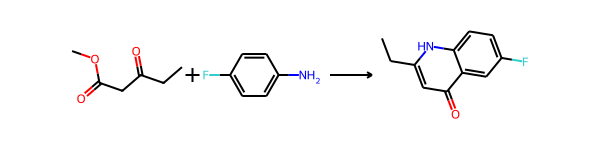

In [63]:
rdChemReactions.ReactionFromSmarts(df['issue'].dropna()[195]['reactions'], useSmiles=True)

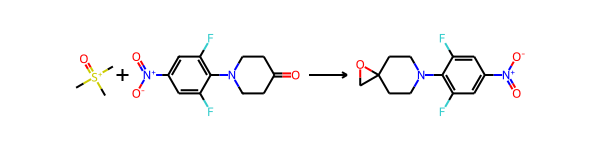

In [65]:
rdChemReactions.ReactionFromSmarts(df['issue'].dropna()[197]['reactions'], useSmiles=True)

# Unsolved MCS

In [26]:
import sys
import pandas as pd
import numpy as np
sys.path.append('../')
from SynRBL.rsmi_utils import load_database
from SynRBL.SynMCS.find_missing_graphs import find_missing_parts_pairs
rabalace = pd.DataFrame(load_database('../Data/rebalanced_all.json.gz'))
rabalace = rabalace.applymap(lambda x: np.nan if x == [] else x)
fail = rabalace['issue'].dropna().to_list()

/var/folders/t0/4s7kmdv11y93hgspz_xf83jc0000gn/T/ipykernel_55070/1993456944.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  rabalace = rabalace.applymap(lambda x: np.nan if x == [] else x)


In [144]:
from rdkit import Chem
from rdkit.Chem import rdmolops
from rdkit.Chem import rdFMCS

class MCSMissingGraphAnalyzer:
    """A class for detecting missing graph in reactants and products using MCS and RDKit."""

    def __init__(self):
        """Initialize the MolecularOperations class."""
        pass
    
    @staticmethod
    def get_smiles(reaction_dict):
        """
        Extract reactant and product SMILES strings from a reaction dictionary.

        Parameters:
        - reaction_dict: dict
            A dictionary containing 'reactants' and 'products' as keys.

        Returns:
        - tuple
            A tuple containing reactant SMILES and product SMILES strings.
        """
        return reaction_dict['reactants'], reaction_dict['products']

    @staticmethod
    def convert_smiles_to_molecule(smiles):
        """
        Convert a SMILES string to an RDKit molecule object.

        Parameters:
        - smiles: str
            The SMILES string representing a molecule.

        Returns:
        - rdkit.Chem.Mol
            The RDKit molecule object.
        """
        return Chem.MolFromSmiles(smiles)

    @staticmethod
    def mol_to_smiles(mol):
        """
        Convert an RDKit molecule object to a SMILES string.

        Parameters:
        - mol: rdkit.Chem.Mol
            The RDKit molecule object.

        Returns:
        - str or None
            The SMILES string representation of the molecule, or None if the molecule is None.
        """
        return Chem.MolToSmiles(mol) if mol else None

    @staticmethod
    def mol_to_smarts(mol):
        """
        Convert an RDKit molecule object to a SMARTS string.

        Parameters:
        - mol: rdkit.Chem.Mol
            The RDKit molecule object.

        Returns:
        - str or None
            The SMARTS string representation of the molecule, or None if the molecule is None.
        """
        return Chem.MolToSmarts(mol) if mol else None

    @staticmethod
    def find_maximum_common_substructure(mol1, mol2, ringMatchesRingOnly=True):
        """
        Find the maximum common substructure (MCS) between two molecules.

        Parameters:
        - mol1, mol2: rdkit.Chem.Mol
            The RDKit molecule objects to compare.

        Returns:
        - rdkit.Chem.Mol or None
            The RDKit molecule object representing the MCS, or None if MCS search was canceled.
        """
        mcs_result = rdFMCS.FindMCS([mol1, mol2], ringMatchesRingOnly=ringMatchesRingOnly)
        if mcs_result.canceled:
            return None
        mcs_mol = Chem.MolFromSmarts(mcs_result.smartsString)
        return mcs_mol

    @staticmethod
    def IterativeMCSReactionPairs(reactant_mol_list, product_mol, params=None):
        """
        Find the MCS for each reactant fragment with the product, updating the product after each step.
        Reactants are processed based on the size of their MCS with the product at each iteration.

        Parameters:
        - reactant_mol_list: list of rdkit.Chem.Mol
            List of RDKit molecule objects for reactants.
        - product_mol: rdkit.Chem.Mol
            RDKit molecule object for the product.

        Returns:
        - list of rdkit.Chem.Mol
            List of RDKit molecule objects representing the MCS for each reactant-product pair.
        - list of rdkit.Chem.Mol
            Sorted list of reactant molecule objects.
        """
        from rdkit.Chem import rdFMCS
        from rdkit import Chem

        # Calculate the MCS for each reactant with the product
        mcs_results = [(reactant, rdFMCS.FindMCS([reactant, product_mol], params)) for reactant in reactant_mol_list]

        # Filter out any canceled MCS results and sort by size of MCS
        mcs_results = [(reactant, mcs_result) for reactant, mcs_result in mcs_results if not mcs_result.canceled]
        sorted_reactants = sorted(mcs_results, key=lambda x: x[1].numAtoms, reverse=True)

        # Run Iteractive MCS
        mcs_list = []
        current_product = product_mol
        for reactant, _ in sorted_reactants:
            # Calculate the MCS with the current product
            mcs_result = rdFMCS.FindMCS([reactant, current_product], params)
            
            if not mcs_result.canceled:
                display(current_product)
                mcs_mol = Chem.MolFromSmarts(mcs_result.smartsString)
                display(mcs_mol)
                mcs_list.append(mcs_mol)
                
                # Update the product by removing the MCS substructure
                current_product = Chem.DeleteSubstructs(Chem.RWMol(current_product), mcs_mol)
                display(current_product)
                
                try:
                    Chem.SanitizeMol(current_product)
                except:
                    pass

                # Check for invalid cases
                #if mcs_mol.GetNumAtoms() <= current_product.GetNumAtoms():
                    #raise ValueError("Invalid MCS: Number of atoms in MCS is less than or equal to the number of atoms in the current product.")
        # Extract only the reactant molecules from sorted_reactants for return
        sorted_reactant_mols = [reactant for reactant, _ in sorted_reactants]

        return mcs_list, sorted_reactant_mols

    
    @staticmethod
    def add_hydrogens_to_radicals(mol):
        """
        Add hydrogen atoms to radical sites in a molecule.

        Parameters:
        - mol: rdkit.Chem.Mol
            RDKit molecule object.

        Returns:
        - rdkit.Chem.Mol
            The modified molecule with added hydrogens.
        """
        if mol:
            # Create a copy of the molecule
            mol_with_h = Chem.RWMol(mol)

            # Add explicit hydrogens (not necessary if they are already present in the input molecule)
            mol_with_h = rdmolops.AddHs(mol_with_h)

            # Find and process radical atoms
            for atom in mol_with_h.GetAtoms():
                num_radical_electrons = atom.GetNumRadicalElectrons()
                if num_radical_electrons > 0:
                    atom.SetNumExplicitHs(atom.GetNumExplicitHs() + num_radical_electrons)
                    atom.SetNumRadicalElectrons(0)
            curate_mol = Chem.RemoveHs(mol_with_h)
            # Return the molecule with added hydrogens
            return curate_mol

    @staticmethod
    def fit(reaction_dict, RingMatchesRingOnly=True, CompleteRingsOnly=True, AtomCompare=False, BondTyper = False):
        """
        Process a reaction dictionary to find MCS, missing parts in reactants and products.

        Parameters:
        - reaction_dict: dict
            A dictionary containing 'reactants' and 'products' as keys.

        Returns:
        - tuple
            A tuple containing lists of MCS, missing parts in reactants, missing parts in products,
            reactant molecules, and product molecules.
        """
        
        # define parameters
        params = rdFMCS.MCSParameters()
        #params.AtomTyper = rdFMCS.AtomCompare.CompareElements
        #params.BondTyper = rdFMCS.BondCompare.CompareOrder
        params.BondCompareParameters.RingMatchesRingOnly = RingMatchesRingOnly
        params.BondCompareParameters.CompleteRingsOnly = CompleteRingsOnly


        # Calculate the MCS for each reactant with the product 
        reactant_smiles, product_smiles = MCSMissingGraphAnalyzer.get_smiles(reaction_dict)
        reactant_mol_list = [MCSMissingGraphAnalyzer.convert_smiles_to_molecule(smiles) for smiles in reactant_smiles.split('.')]
        product_mol = MCSMissingGraphAnalyzer.convert_smiles_to_molecule(product_smiles)

        mcs_list, sorted_reactants = MCSMissingGraphAnalyzer.IterativeMCSReactionPairs(reactant_mol_list, product_mol,  params)

        return mcs_list , sorted_reactants, product_mol

In [145]:
test = fail[10]

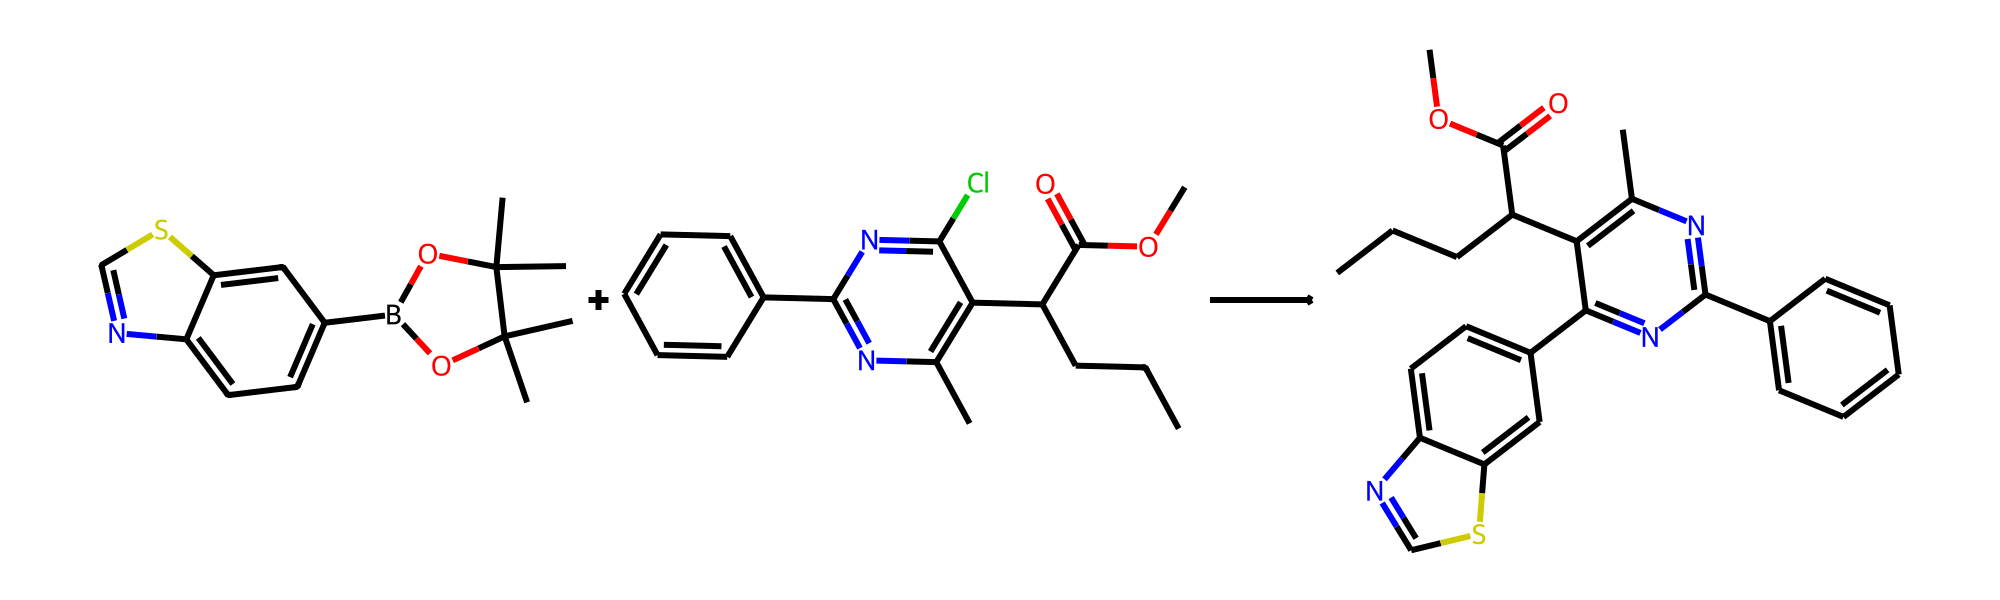

In [146]:
from SynRBL.SynVis import ReactionVisualizer
vis = ReactionVisualizer()
vis.visualize_reaction(test['reactions'])

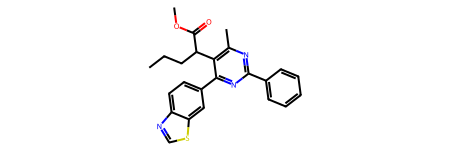

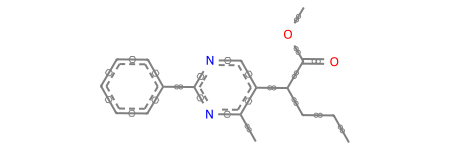

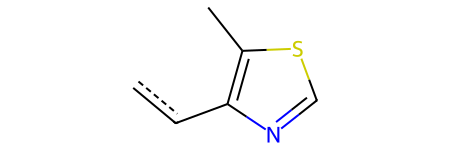

[22:05:39] non-ring atom 0 marked aromatic


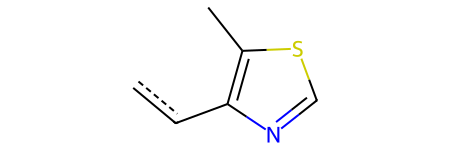

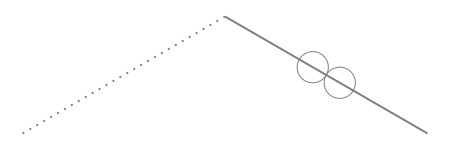

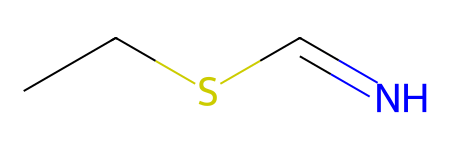

[22:05:39] non-ring atom 0 marked aromatic


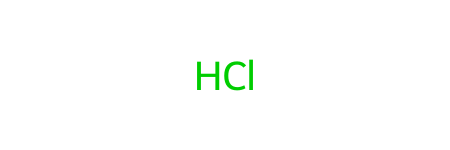

In [162]:
analyzer = MCSMissingGraphAnalyzer()
#mcs_list, sorted_reactants, product_mol = analyzer.fit(test,  RingMatchesRingOnly=False, CompleteRingsOnly=False)
mcs_list, sorted_reactants, product_mol = analyzer.fit(test,  RingMatchesRingOnly=True, CompleteRingsOnly=True)
impute_product_frags, boundary_atoms_products, nearest_neighbor_products = find_missing_parts_pairs(sorted_reactants, mcs_list)
impute_product_frags[0]

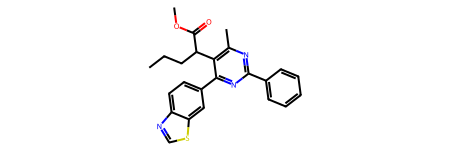

In [163]:
product_mol

In [157]:
Chem.SanitizeMol(mcs_list[0])

rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE

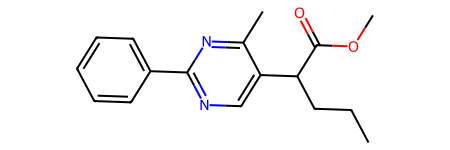

In [160]:
Chem.MolFromSmiles(Chem.MolToSmiles(mcs_list[0]))

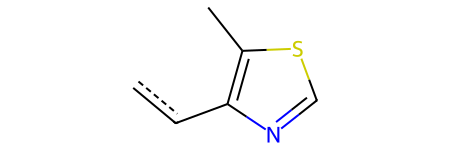

In [173]:
Chem.DeleteSubstructs(Chem.RWMol(product_mol), Chem.MolFromSmiles(Chem.MolToSmiles(mcs_list[0])), onlyFrags=False)

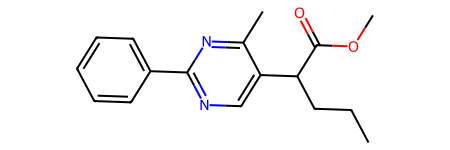

In [172]:
Chem.MolFromSmiles(Chem.MolToSmiles(mcs_list[0]))

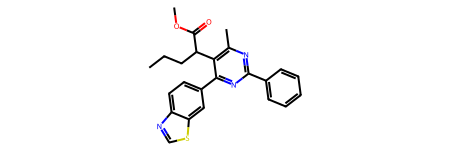

In [174]:
product_mol

In [178]:
# Find the substructure in the molecule
substructure_matches = product_mol.GetSubstructMatches(mcs_list[0])
substructure_matches

((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 19, 20, 13, 14, 15, 16, 17, 18),
 (0, 1, 2, 3, 4, 5, 6, 7, 8, 20, 21, 19, 12, 11, 9, 13, 14, 15, 16, 17, 18))

In [180]:
from rdkit import Chem

# Assuming you have a molecule (mol) and a substructure (substructure_mol)
mol = product_mol
substructure_mol = mcs_list[0]

# Find the substructure matches
substructure_matches = mol.GetSubstructMatches(substructure_mol)

# Compile a unique set of atom indices from all matches
unique_atom_indices = set(idx for match in substructure_matches for idx in match)

# Initialize a modifiable molecule
rw_mol = Chem.RWMol(mol)

# Remove atoms by iterating over the unique sorted indices in descending order
for atom_idx in sorted(unique_atom_indices, reverse=True):
    rw_mol.RemoveAtom(atom_idx)

# Convert the modified molecule back to a regular molecule
updated_mol = rw_mol.GetMol()

# Convert to SMILES or any other format as needed
updated_smiles = Chem.MolToSmiles(updated_mol)



In [183]:
substructure_matches

((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 19, 20, 13, 14, 15, 16, 17, 18),
 (0, 1, 2, 3, 4, 5, 6, 7, 8, 20, 21, 19, 12, 11, 9, 13, 14, 15, 16, 17, 18))

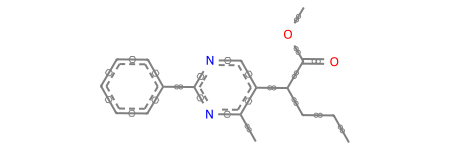

In [182]:
substructure_mol

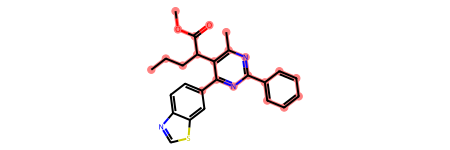

In [184]:
mol

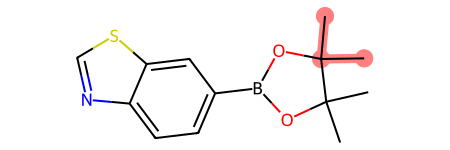

In [138]:
sorted_reactants[1]

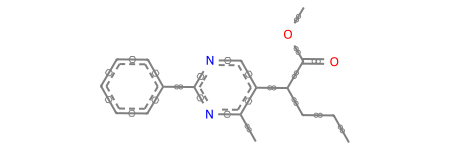

In [143]:
mcs_list[0]

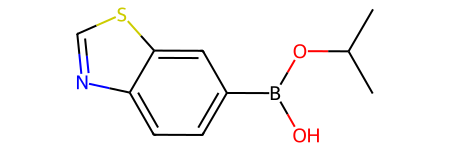

In [134]:
impute_product_frags[1]

In [111]:
nearest_neighbor_products

[[{'C': 4}, {'C': 4}]]

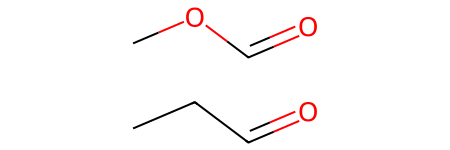

In [109]:
impute_product_frags[0]

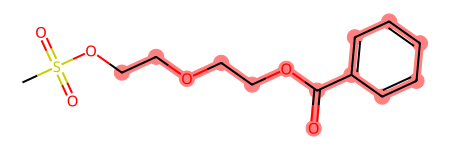

In [96]:
sorted_reactants[0]

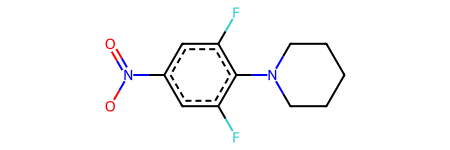

In [90]:
mcs_list[0]

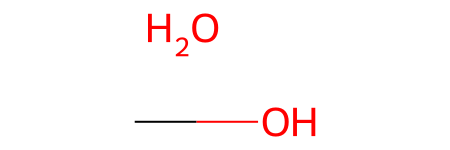

In [80]:
impute_product_frags[1]

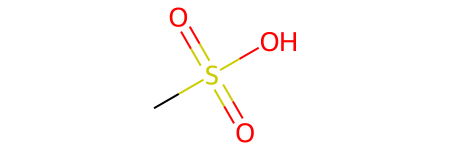

In [59]:
impute_product_frags[0]

In [31]:
impute_product_frags

In [18]:
fail

[{'id': 'US20100331306A1',
  'class': 4,
  'reactions': 'CCC(=O)CC(=O)OC.Nc1ccc(F)cc1>>CCc1cc(=O)c2cc(F)ccc2[nH]1',
  'reactants': 'CCC(=O)CC(=O)OC.Nc1ccc(F)cc1',
  'products': 'CCc1cc(=O)c2cc(F)ccc2[nH]1',
  'Unbalance': 'Products',
  'Diff_formula': {'C': 1, 'O': 2, 'H': 6}},
 {'id': 'US20130296569A1',
  'class': 4,
  'reactions': 'C[S+](C)(C)=O.O=C1CCN(c2c(F)cc([N+](=O)[O-])cc2F)CC1>>O=[N+]([O-])c1cc(F)c(N2CCC3(CC2)CO3)c(F)c1',
  'reactants': 'C[S+](C)(C)=O.O=C1CCN(c2c(F)cc([N+](=O)[O-])cc2F)CC1',
  'products': 'O=[N+]([O-])c1cc(F)c(N2CCC3(CC2)CO3)c(F)c1',
  'Unbalance': 'Products',
  'Diff_formula': {'C': 2, 'S': 1, 'O': 1, 'H': 7, 'Q': 1}},
 {'id': 'US07507740B2',
  'class': 1,
  'reactions': 'CS(=O)(=O)OCCOCCOC(=O)c1ccccc1.CSc1ncnc2cn[nH]c12>>CSc1ncnc2cnn(CCOCCOC(=O)c3ccccc3)c12',
  'reactants': 'CS(=O)(=O)OCCOCCOC(=O)c1ccccc1.CSc1ncnc2cn[nH]c12',
  'products': 'CSc1ncnc2cnn(CCOCCOC(=O)c3ccccc3)c12',
  'Unbalance': 'Products',
  'Diff_formula': {'C': 1, 'S': 1, 'O': 3, 'H': 4}},
